In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib as ta
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
def train_model(df,value):
    split =int(.8*len(df))
    
    pca = PCA(n_components=0.95)
    pca.fit(df)
    df_trans=pca.transform(df)
    
    data_use=scale(df)

    X_train = data_use[:split]
    X_test = data_use[split:]
    y_train = value[:split].values.reshape((-1, 1))
    y_test = value[split:].values.reshape((-1, 1))

    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    grid = GridSearchCV(SVC(), param_grid={"C":[0.01,0.1, 1, 10,100], "gamma": [100,10,1,0.1,0.01]}, cv=4)
    grid.fit(X_train, y_train)
    print("The best parameters are %s with a score of %0.2f"
          % (grid.best_params_, grid.best_score_))
    
    correct=0
    L=len(data_use)
    train=split
    total_predict_data=L-train

    while train<L:
        Data_predict = data_use[train:train+1]
        value_real = value[train:train+1]
        classifier= SVC(C=grid.best_params_['C'],gamma=grid.best_params_['gamma'], kernel='rbf')
        classifier.fit(X_train,y_train)
        value_predict=classifier.predict(Data_predict)

        if(value_real[0]==int(value_predict)):
            correct=correct+1
        train = train+1

    correct=correct/total_predict_data*100
    print("Correct = ",correct,"%")
    
    pred=classifier.predict(data_use)
    
    return pred

In [4]:
data_input = pd.read_csv('index.csv',
                   delimiter=',',
                   converters={'Indexcd':str})
data_input=data_input.set_index(['Indexcd','Trddt'])

In [8]:
index_data=data_input.loc['000300']
index_data.head()

,Opnindex,Hiindex,Loindex,Clsindex,Retindex
Trddt,,,,,
2017/1/3,3313.953,3345.263,3313.953,3342.227,0.009712
2017/1/4,3340.558,3369.566,3338.153,3368.312,0.007805
2017/1/5,3368.340,3373.412,3361.462,3367.789,-0.000155
2017/1/6,3366.852,3368.870,3346.891,3347.666,-0.005975
2017/1/9,3345.748,3366.222,3344.347,3363.901,0.004850


No handles with labels found to put in legend.


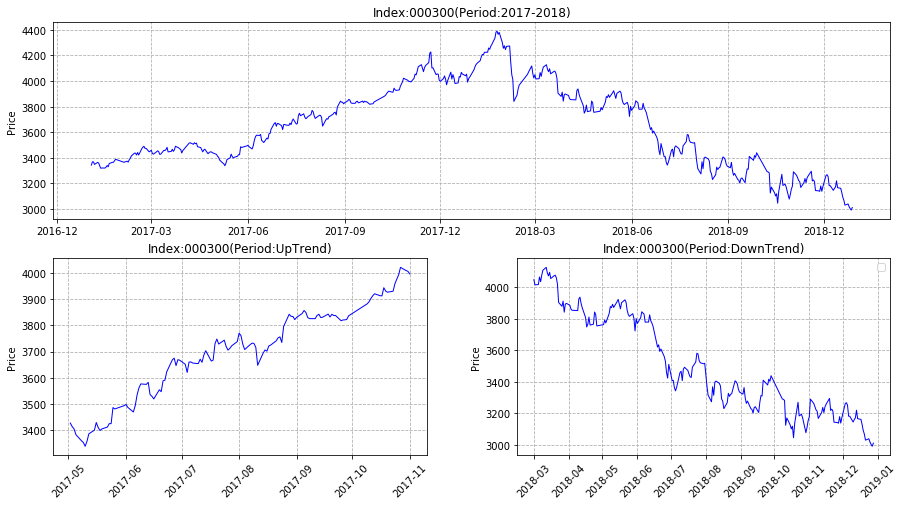

In [33]:
import datetime
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.dates as mdates

price1=index_data['Clsindex'].values
dates1=index_data['Clsindex'].index.values
dates1=pd.DatetimeIndex(dates1)

start_time1='2017/5/2'
end_time1='2017/11/1'
price2=index_data[start_time1:end_time1]['Clsindex'].values
dates2=index_data[start_time1:end_time1]['Clsindex'].index.values
dates2=pd.DatetimeIndex(dates2)

start_time2='2018/3/1'
end_time2='2018/12/28'
price3=index_data[start_time2:end_time2]['Clsindex'].values
dates3=index_data[start_time2:end_time2]['Clsindex'].index.values
dates3=pd.DatetimeIndex(dates3)


fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot2grid((12,11),(0,0),rowspan=5,colspan=11)
ax1.set_title('Index:000300(Period:2017-2018)')
ax1.set_ylabel("Price")
ax1.plot(dates1,price1,color='blue',linewidth=1.0)
plt.grid(ls="--")
    
ax2 = plt.subplot2grid((12,11),(6,0),rowspan=5,colspan=5)
ax2.set_title("Index:000300(Period:UpTrend)")
ax2.set_ylabel("Price")
ax2.plot(dates2,price2,color='blue',linewidth=1.0)
plt.grid(ls="--")

ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
for label in ax2.xaxis.get_ticklabels():
    label.set_rotation(45)
      
    
ax3 = plt.subplot2grid((12,11),(6,6),rowspan=5,colspan=5)
ax3.set_title("Index:000300(Period:DownTrend)")
ax3.set_ylabel("Price")
ax3.plot(dates3,price3,color='blue',linewidth=1.0)
plt.grid(ls="--")

ax3.xaxis.set_major_locator(mdates.MonthLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
for label in ax3.xaxis.get_ticklabels():
    label.set_rotation(45)
    
    
plt.subplots_adjust(bottom=0.13,top=0.95,hspace=0)
plt.legend(loc='best')
plt.grid(ls="--")

plt.show()

In [38]:
start_time1='2017/5/2'
end_time1='2017/11/1'
data1=pd.DataFrame(index_data[start_time1:end_time1])

start_time2='2018/3/1'
end_time2='2018/12/28'
data2=pd.DataFrame(index_data[start_time2:end_time2])

In [64]:
n = 10

data=pd.DataFrame(index=data2.index)

#shift to yesterday
data['Open']=data2['Opnindex'].shift(1)
data['High']=data2['Hiindex'].shift(1)
data['Low']=data2['Loindex'].shift(1)
data['Close']=data2['Clsindex'].shift(1)

data['High-Low'] = data['High']-data['Low']
data['Close-YClose']=data['Close']-data['Close'].shift(1)

close = [float(x) for x in data['Close']]
high = [float(x) for x in data['High']]
low = [float(x) for x in data['Low']]

data['MA']=ta.MA(np.array(data['Close']), timeperiod=n) 
data['RSI']=ta.RSI(np.array(close), timeperiod=n)
data['SMA']= data['Close'].rolling(window=n).mean()
data['SAR']=ta.SAR(np.array(high),np.array(low),0.2,0.2)
data['ADX']=ta.ADX(np.array(high),np.array(low),np.array(close), timeperiod =n)
data['MOM']=ta.MOM(np.array(close), timeperiod=n)
data['ROC']=ta.ROC(np.array(close), timeperiod=n)
# data['AD']=ta.AD(np.array(high), np.array(low), np.array(close), np.array(data['volume']))
data['Return']= np.log(data['Close']/data['Close'].shift(1))
data.head()

,Open,High,Low,Close,High-Low,Close-YClose,MA,RSI,SMA,SAR,ADX,MOM,ROC,Return
Trddt,,,,,,,,,,,,,,
2018/3/1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018/3/2,3994.869,4061.033,3986.895,4049.086,74.138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018/3/5,4014.951,4044.418,4006.943,4016.461,37.475,-32.625,NaN,NaN,NaN,3986.895,NaN,NaN,NaN,-0.008090
2018/3/6,4021.657,4042.835,3995.872,4018.097,46.963,1.636,NaN,NaN,NaN,4044.418,NaN,NaN,NaN,0.000407
2018/3/7,4034.985,4067.552,3998.932,4066.565,68.620,48.468,NaN,NaN,NaN,3995.872,NaN,NaN,NaN,0.011990


In [65]:
data_drop=data.dropna()
data_drop

,Open,High,Low,Close,High-Low,Close-YClose,MA,RSI,SMA,SAR,ADX,MOM,ROC,Return
Trddt,,,,,,,,,,,,,,
2018/3/29,3865.045,3907.281,3835.883,3842.715,71.398,-70.554,3992.6750,27.504196,3992.6750,3985.091040,31.284282,-230.630,-5.661931,-0.018194
2018/3/30,3854.591,3913.958,3794.262,3894.050,119.696,51.335,3972.4637,37.013551,3972.4637,3954.056032,32.317138,-202.113,-4.934203,0.013271
2018/4/2,3893.747,3915.347,3879.213,3898.498,36.134,4.448,3956.6712,37.799047,3956.6712,3922.097226,33.185106,-157.925,-3.893208,0.001142
2018/4/3,3897.005,3937.018,3882.886,3886.919,54.132,-11.579,3937.9383,36.483059,3937.9383,3794.262000,32.977567,-187.329,-4.597879,-0.002975
2018/4/4,3850.155,3878.150,3839.933,3862.480,38.217,-24.439,3916.4159,33.729170,3916.4159,3822.813200,33.712339,-215.224,-5.278068,-0.006307
2018/4/9,3873.627,3898.613,3852.496,3854.863,46.117,-7.617,3895.7972,32.869934,3895.7972,3839.933000,33.445691,-206.187,-5.077184,-0.001974
2018/4/10,3851.955,3870.674,3827.413,3852.929,43.261,-1.934,3879.0552,32.635390,3879.0552,3937.018000,33.775428,-167.420,-4.164315,-0.000502
2018/4/11,3860.722,3927.425,3851.796,3927.173,75.629,74.244,3881.2789,48.354315,3881.2789,3827.413000,31.720417,22.237,0.569459,0.019086
2018/4/12,3934.170,3958.707,3924.960,3938.343,33.747,11.170,3887.1239,50.293217,3887.1239,3827.413000,28.791914,58.450,1.506485,0.002840


In [103]:
value1 = data_drop["Close-YClose"].shift(-1)
# value1 = data["Return"].shift(-1)
value1 = value1.bfill()
value1[value1>0]=1
value1[value1==0]=0
value1[value1<0]=-1

In [104]:
pred1=train_model(data_drop,value1)

(116, 13)
(116, 1)
(29, 13)
(29, 1)
The best parameters are {'C': 10, 'gamma': 0.1} with a score of 0.60
Correct =  44.827586206896555 %


In [107]:
signals=pd.DataFrame(index=data_drop.index)

signals['signal'] = 0.0
signals['signal'] = pred1
signals['signal']= signals['signal'].shift(-1)
signals['ground_truth']=value1
signals['data']=data3['Clsindex']

signals['signal'] = signals['signal'].bfill()
signals=signals.dropna()

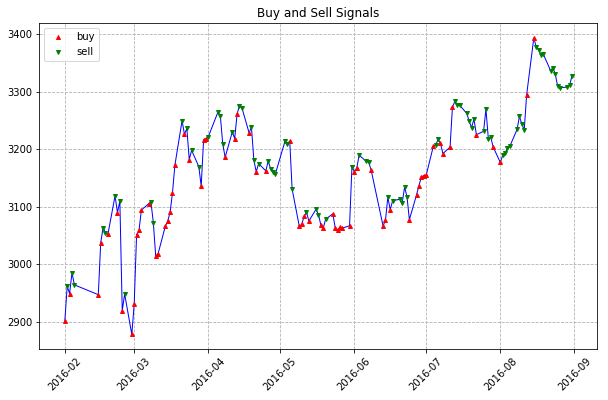

In [108]:
dates=pd.DatetimeIndex(signals['data'].index.values)

fig,ax1 =plt.subplots(figsize=(10,6))
ax1.plot(dates,signals['data'].values,color='b',lw=1.0)

y=signals[signals['signal']==1.0]['data'].values
x=pd.DatetimeIndex(signals[signals['signal']==1.0]['data'].index.values)
ax1.plot(x,y,'^', markersize=4, color='red',label='buy')
y=signals[signals['signal']==-1.0]['data'].values
x=pd.DatetimeIndex(signals[signals['signal']==-1.0]['data'].index.values)
ax1.plot(x,y,'v', markersize=4, color='green',label='sell')

# ax1.plot(signals[signals['signal']==1.0]['data'],'^', markersize=5, color='red',label='buy')
# ax1.plot(signals[signals['signal']==-1.0]['data'],'^', markersize=5, color='green',label='sell')

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(45)

# Show the plot
plt.legend(loc='best')
plt.title('Buy and Sell Signals')
plt.grid(ls="--")
    
plt.show()

In [109]:
df=pd.DataFrame(index=data_drop.index)
# df['return'] = data_drop[start_time1:end_time1]['Clsprc'].pct_change()
df['return']=signals['data'].pct_change()
df['strategy'] = signals['signal']*df['return'].shift(-1)
df['return_cum'] = (df['return'] + 1).cumprod()
df['strategy_cum'] = (df['strategy'] + 1).cumprod()
df=df.dropna()

In [110]:
def ratio(df):
    return_year=df.mean()*252
    volatility=df.std()*252**0.5
    strategy_cum=(df+1).cumprod()
    drawdown=(strategy_cum.cummax()-strategy_cum).max()
    sharpe_ratio = np.sqrt(252) * (df.mean() / df.std()) 
    res = pd.DataFrame([return_year, volatility, drawdown, sharpe_ratio],columns=[df.name],index=['return', 'volatility', 'drawdown','sharpe ratio'])
    return res
ratio(df['return']).join(ratio(df['strategy']))

,return,strategy
return,0.253835,1.302122
volatility,0.193358,0.173603
drawdown,0.083212,0.077381
sharpe ratio,1.312769,7.500591


Text(0.5,1,'Backtest')

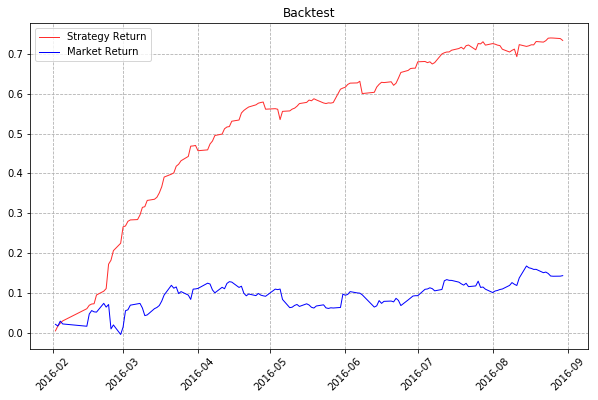

In [111]:
df['Market Return'] = df['return']
df['Strategy Return'] = df['strategy']
fig,ax1 =plt.subplots(figsize=(10,6))
dates=pd.DatetimeIndex(df.index.values)

ax1.plot(dates,df['Strategy Return'].cumsum(),color='#FF2D2D',lw=1.0)
ax1.plot(dates,df['Market Return'].cumsum(),color='b',lw=1.0)
# df['Strategy Return'].cumsum().plot(color='#F75000',lw=1.0)
# df['Market Return'].cumsum().plot(color='#0072E3',lw=1.0)

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(45)
plt.legend(loc='best')
plt.grid(ls="--")
plt.title('Backtest')

In [80]:
data_input = pd.read_csv('index2.csv',
                   delimiter=',',
                   converters={'Indexcd':str})
data_input=data_input.set_index(['Indexcd','Trddt'])

In [81]:
index_data2=data_input.loc['000300']

No handles with labels found to put in legend.


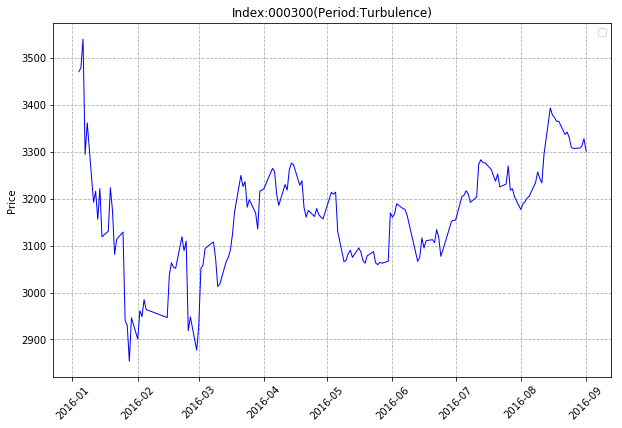

In [97]:
import datetime
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.dates as mdates

start_time1='2016/1/4'
end_time1='2016/9/1'
price2=index_data2['Clsindex'][start_time1:end_time1].values
dates2=index_data2['Clsindex'][start_time1:end_time1].index.values
dates2=pd.DatetimeIndex(dates2)


fig = plt.figure(figsize=(10,6))
ax1 = plt.subplot(111)
ax1.set_title("Index:000300(Period:Turbulence)")
ax1.set_ylabel("Price")
ax1.plot(dates2,price2,color='blue',linewidth=1.0)
plt.grid(ls="--")

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(45)

    
plt.subplots_adjust(bottom=0.13,top=0.95,hspace=0)
plt.legend(loc='best')
plt.grid(ls="--")

plt.show()

In [99]:
data3=index_data2[start_time1:end_time1]
data3.head()

,Opnindex,Hiindex,Loindex,Clsindex,Retindex
Trddt,,,,,
2016/1/4,3725.856,3726.245,3469.011,3470.411,-0.069846
2016/1/5,3382.177,3518.217,3377.280,3478.780,0.002800
2016/1/6,3482.406,3543.739,3468.467,3539.808,0.017543
2016/1/7,3481.150,3481.150,3284.737,3294.384,-0.069333
2016/1/8,3371.871,3418.851,3237.931,3361.563,0.020392


In [101]:
n = 10

data=pd.DataFrame(index=data3.index)
#shift to yesterday
data['Open']=data3['Opnindex'].shift(1)
data['High']=data3['Hiindex'].shift(1)
data['Low']=data3['Loindex'].shift(1)
data['Close']=data3['Clsindex'].shift(1)

data['High-Low'] = data['High']-data['Low']
data['Close-YClose']=data['Close']-data['Close'].shift(1)

close = [float(x) for x in data['Close']]
high = [float(x) for x in data['High']]
low = [float(x) for x in data['Low']]

data['MA']=ta.MA(np.array(data['Close']), timeperiod=n) 
data['RSI']=ta.RSI(np.array(close), timeperiod=n)
data['SMA']= data['Close'].rolling(window=n).mean()
data['SAR']=ta.SAR(np.array(high),np.array(low),0.2,0.2)
data['ADX']=ta.ADX(np.array(high),np.array(low),np.array(close), timeperiod =n)
data['MOM']=ta.MOM(np.array(close), timeperiod=n)
data['ROC']=ta.ROC(np.array(close), timeperiod=n)
# data['AD']=ta.AD(np.array(high), np.array(low), np.array(close), np.array(data['volume']))
# data['Return']= np.log(data['Close']/data['Close'].shift(1))
data.head()

,Open,High,Low,Close,High-Low,Close-YClose,MA,RSI,SMA,SAR,ADX,MOM,ROC
Trddt,,,,,,,,,,,,,
2016/1/4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016/1/5,3725.856,3726.245,3469.011,3470.411,257.234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016/1/6,3382.177,3518.217,3377.280,3478.780,140.937,8.369,NaN,NaN,NaN,3726.2450,NaN,NaN,NaN
2016/1/7,3482.406,3543.739,3468.467,3539.808,75.272,61.028,NaN,NaN,NaN,3656.4520,NaN,NaN,NaN
2016/1/8,3481.150,3481.150,3284.737,3294.384,196.413,-245.424,NaN,NaN,NaN,3600.6176,NaN,NaN,NaN


In [102]:
data_drop=data.dropna()